In [1]:
import torch
from torch import optim, nn, utils, Tensor
import lightning as L

import numpy as np
import matplotlib.pyplot as plt

from Network import Generator, Discriminator
from Signal_Generator import *
from Signal_Analyzer import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = []

for i in range(10):
    SG = Signal_Generator(num_sources=1, noise_amplitude=1)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = torch.tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = torch.tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_loader = utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

num_latent_variables = 10
learning_rate = 0.0001

In [3]:
class GAN():
    def __init__(self, dataset, num_latent_variables, lr):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)
        self.criterion = nn.BCELoss()

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def adversarial_loss(self, output_d, y):
        return self.criterion(output_d, y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = self.adversarial_loss(fake_output, torch.ones_like(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        real_loss = self.adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = self.adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2
        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        return d_loss.item()

In [5]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

d_loss_list = []
# Train the GAN
for i in range(500):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        d_loss_list.append(d_loss)
    print(f"Epoch {i}, Discriminator loss: {d_loss}")

Epoch 0, Discriminator loss: 0.6103736162185669
Epoch 1, Discriminator loss: 0.4586426913738251
Epoch 2, Discriminator loss: 0.08554631471633911
Epoch 3, Discriminator loss: 0.04793523997068405
Epoch 4, Discriminator loss: 0.029579130932688713
Epoch 5, Discriminator loss: 0.02718707174062729
Epoch 6, Discriminator loss: 0.01659131608903408
Epoch 7, Discriminator loss: 0.017424246296286583
Epoch 8, Discriminator loss: 0.011122768744826317
Epoch 9, Discriminator loss: 0.01295013539493084
Epoch 10, Discriminator loss: 0.00799653586000204
Epoch 11, Discriminator loss: 0.008804685436189175
Epoch 12, Discriminator loss: 0.007441840134561062
Epoch 13, Discriminator loss: 0.006603815592825413
Epoch 14, Discriminator loss: 0.005590219050645828
Epoch 15, Discriminator loss: 0.005783941596746445
Epoch 16, Discriminator loss: 0.006288745440542698
Epoch 17, Discriminator loss: 0.004813989624381065
Epoch 18, Discriminator loss: 0.004871400538831949
Epoch 19, Discriminator loss: 0.004946405068039894


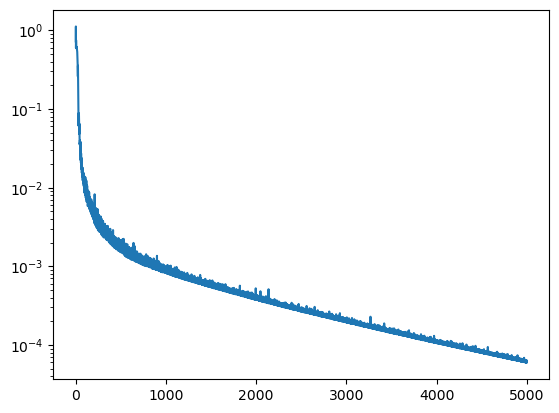

In [6]:
plt.plot(d_loss_list)
plt.yscale('log')

In [7]:
g_loss_list = []
d_loss_list = []

for epoch in range(500):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        g_loss = gan.train_generator(signal_tensor, z)
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        g_loss_list.append(g_loss)
        d_loss_list.append(d_loss)
    print(f"Epoch {epoch}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")

c:\Users\Administrater\.conda\envs\MasLISA\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Generator loss: 0.9598954916000366, Discriminator loss: 0.4602241814136505
Epoch 1, Generator loss: 0.5524179339408875, Discriminator loss: 0.628926694393158
Epoch 2, Generator loss: 0.8993642926216125, Discriminator loss: 0.6622500419616699
Epoch 3, Generator loss: 0.6609662175178528, Discriminator loss: 0.6545752286911011
Epoch 4, Generator loss: 0.8864288330078125, Discriminator loss: 0.6450120210647583
Epoch 5, Generator loss: 0.6938309669494629, Discriminator loss: 0.6697636246681213
Epoch 6, Generator loss: 0.7026347517967224, Discriminator loss: 0.7234135866165161
Epoch 7, Generator loss: 0.765996515750885, Discriminator loss: 0.72740638256073
Epoch 8, Generator loss: 0.7653149366378784, Discriminator loss: 0.8561668992042542
Epoch 9, Generator loss: 0.6270281076431274, Discriminator loss: 0.7690722942352295
Epoch 10, Generator loss: 0.6094039678573608, Discriminator loss: 0.7759862542152405
Epoch 11, Generator loss: 0.6626381874084473, Discriminator loss: 0.75011718273

In [8]:
generator = gan.generator
generator.eval()

TS = Signal_Generator(num_sources=1, noise_amplitude=1)
test_data = TS.generating_signal()
params = TS.printing_parameters()

input_signal = test_data['Signal'].values
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

print(params)
print(generated_params)

[9.919144588534241, 0.24315132286719604, 2.431613006718278]
[-209.3833   453.31693  563.98047]


In [9]:
class WGAN():
    def __init__(self, dataset, num_latent_variables, lr, weight_clip):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = -torch.mean(fake_output)

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)


        return d_loss.item()

In [12]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.01)

g_loss_list = []
d_loss_list = []

num_epochs = 500
num_critic = 5

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        signal_tensor = signal_tensor.to(device)
        params_tensor = params_tensor.to(device)
        
        for _ in range(num_critic):
            d_loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        
        for _ in range(3):
            g_loss = wgan.train_generator(signal_tensor, z)
        
        g_loss_list.append(g_loss)
        d_loss_list.append(d_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")


Epoch 1/500, Generator loss: -0.49621060490608215, Discriminator loss: -0.0007853806018829346
Epoch 2/500, Generator loss: -0.498079776763916, Discriminator loss: 0.00013130903244018555
Epoch 3/500, Generator loss: -0.4979937970638275, Discriminator loss: -0.00041872262954711914
Epoch 4/500, Generator loss: -0.49821776151657104, Discriminator loss: -0.00043952465057373047
Epoch 5/500, Generator loss: -0.4977778494358063, Discriminator loss: -0.0004678070545196533
Epoch 6/500, Generator loss: -0.49880266189575195, Discriminator loss: -9.953975677490234e-06
Epoch 7/500, Generator loss: -0.49870944023132324, Discriminator loss: 0.000183790922164917
Epoch 8/500, Generator loss: -0.49898388981819153, Discriminator loss: 0.0001569986343383789
Epoch 9/500, Generator loss: -0.4985247254371643, Discriminator loss: -0.0007760822772979736
Epoch 10/500, Generator loss: -0.49864208698272705, Discriminator loss: -0.00023487210273742676
Epoch 11/500, Generator loss: -0.4989367723464966, Discriminator

In [11]:
generator = wgan.generator
generator.eval()

for i in range(10):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    print(params)
    print(generated_params)

[11.516662638377852, 0.35131111238062546, 0.7761564027388659]
[8.10767    0.03027448 1.7619146 ]
[11.386962099568967, 0.2691621545406089, 5.227371338521358]
[8.9362335 0.8399225 1.6329257]
[11.24123948164049, 0.3038955280462225, 2.936260514270033]
[7.901222  0.9078885 2.0599055]
[9.211320514478482, 0.24156178786844032, 3.04782728482806]
[ 8.445425   -0.01911383  2.1105208 ]
[8.2615674281253, 0.3644684677908152, 3.04634042010434]
[ 8.28656   -1.0420303  2.4901261]
[12.295280524941665, 0.4624376439106851, 2.5764263003770385]
[ 8.960342   -0.17930752  1.3982818 ]
[12.627943419968261, 0.25454700894297994, 1.8112882596879538]
[ 8.485913   -0.05174568  1.833298  ]
[9.326511704200678, 0.2657468423789364, 4.029232419880975]
[8.686554  0.4992325 1.6702275]
[10.856494266360775, 0.2507966523264037, 0.10004731788375429]
[9.125658  1.20937   2.1629944]
[11.075478086171902, 0.3624165609784602, 0.43073710118276265]
[7.0215025  0.57749665 0.42306072]
